In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from scipy import ndimage as ndi

from skimage import (
    exposure, io, morphology, color, feature, filters, util, segmentation
)
import math
#import napari
#from napari.utils import nbscreenshot
from scipy import signal
from skimage.filters import threshold_multiotsu
from skimage.filters import try_all_threshold, gaussian
from skimage.morphology import disk
from skimage.filters import threshold_li
from skimage import measure
import pandas as pd
import os
#import PyDIP as dip
import math
import re
from glob import glob
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import random_walker, clear_border
from scipy import ndimage
from skimage.measure import label, regionprops, regionprops_table
from skimage.exposure import histogram

In [2]:
def slice(im3d):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen=[]
    for i in range(stack_size):
        if hist[i] >= (ups['peak_heights'][0]+2*ups2['peak_heights'][0])/3:
            plt.vlines(i,0,max(hist), colors='y')
            chosen.append(i)
    return chosen

In [3]:
def slice_manual(im3d,start,stop):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen = range(start,stop)
    for i in chosen:
        plt.vlines(i,0,max(hist), colors='y')
    return chosen

In [4]:
def display(im3d, cmap="gray", step=1, chosen = None):
    if chosen is None: 
        chosen = []
    stack_size = im3d.shape[0]
    cols = 5
    rows = math.ceil((stack_size/cols))
    
    h , axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 3*rows))
    #print(h)
    #p1 = get(h,'Position')
    #annotation('rectangle',p1,'FaceAlpha',.2,'FaceColor','red','EdgeColor','red') 
    vmin = im3d.min()
    vmax = im3d.max()
    enum = 0
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        if enum in chosen:
            for axis in ['top','bottom','left','right']:
                #ax.spines[axis].set_linewidth(0.5)
                ax.spines[axis].set_color("red")
                ax.spines[axis].set_linewidth(5)
        ax.set_xticks([])
        ax.set_yticks([])
        enum += 1
    #plt.savefig('foo.png')
    

In [5]:
def display_slice(im, cmap="gray", step=1, chosen = None, savefig = False):
    h , axes = plt.subplots(1,1)
    vmin = im.min()
    vmax = im.max()
    enum = 0
    axes.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)

In [6]:
ResultsDir = "/groups/gerlich/experiments/Experiments_005600/005606/results/second_attempt/"

In [7]:
#Define function to threshold a field of cells using MultiOtsu thresholding from skimage
#apply watershedding and then extract features >>> final output is a dataframe

#To do >>> extract metadata automatically using TIFFFILE

In [8]:
def image_stdev(region, intensities):
    # note the ddof arg to get the sample var if you so desire!
    return np.std(intensities[region], ddof=1)

In [11]:
#background subtraction - mean fluorescence in background of three cells drawn, divided by three to subtract from the mean fluorescence of each channel

#for the Halo TMR background fluorescence, WT cells were stained with Halo-TMR at the same time as SMC4. The Halo TMR fluorescence in the nuclei 
# of WT cells was then measured to correct for background >>> 6 cells from 3 images
#2108 minus auxin - Hoechst, 0.203, 0.094, 0.107 >>> 0.135
#2108 minus auxin, WT background corrected - 5.850, 6.053, 7.084, 5.898, 6.603, 7.343 >>> 6.47





In [11]:
pixel_size = (14.1681)
#this is the number of pixels per micron, change the pixel size according to your specific image
scaling_factor = pixel_size**2




def threshold_field(images):

    
    #Set up variables as empty dataframes
    all_hoechst = pd.DataFrame()
    all_halo= pd.DataFrame()

    #read in files
    for image in images:
        data = io.imread(image)
        #select channels, wapl = channel3, Scc1 = channel2, Hoechst = channel 1 in this image
        hoechst = data[0,:,:]
        halo = data[1,:,:]
        #display_slice(wapl_ha)
        
          
        #hoechst[hoechst < 10] = 0
        
        
        sigma = 1.0

        # apply Gaussian blur, creating a new image
        blurred = filters.gaussian(
        hoechst, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
        #display_slice(blurred)


        #threshold the hoechst_channel using multiotsu thresholding
        thresh = threshold_li(blurred)
        #mask = hoechst > thresh
        
        binary_mask = morphology.binary_closing(blurred > thresh, disk(8)) 
        
        #binary_mask = ndimage.binary_fill_holes(blurred).astype(int)
        
        cleared = clear_border(binary_mask)
        remove_debris = morphology.remove_small_objects(cleared, 25000)
        

        #optimise thresholding parameters for this dataset

        #igher_threshold = 60
        #ilt = hoechst > higher_threshold

        #moother_filt = filters.rank.mean(util.img_as_ubyte(remove_debris),
                                      #orphology.disk(4))

        #inal_thresh = smoother_filt > 60

        #apply watershedding to distinguish cells which are thresholded as a single cell when in reality there are two
        distance = ndi.distance_transform_edt(remove_debris)

        local_max_coords = feature.peak_local_max(distance, min_distance=50)
        local_max_mask = np.zeros(distance.shape, dtype=bool)
        local_max_mask[tuple(local_max_coords.T)] = True
        markers = measure.label(local_max_mask)

        segmented_cells = segmentation.watershed(-distance, markers, mask=remove_debris)
        
        remove_small_masks = morphology.remove_small_objects(segmented_cells, 15000)
        
        segmented_cells = remove_small_masks

        #this is the number of pixels per micron, change the pixel size according to your specific image
        #Generate labels, each thresholded object becomes a label
        pixel_size = (14.1681)
        scaling_factor = pixel_size**2

        #Generate labels, each thresholded object becomes a label
        labels = measure.label(segmented_cells)
        properties = measure.regionprops(labels)

        #choose which features to extract and extract features for the first channel. Calculate nuclear area

        properties_hoechst = ["area", "mean_intensity"]
        output_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, 
             properties=properties_hoechst))
        #rename columns
        output_hoechst = output_hoechst.rename(columns={"area":"area_pixels"})
        output_hoechst = output_hoechst.rename(columns={"mean_intensity":"mean_hoechst"})

        #get nuclear area in microns instead of pixels and then calculate total intensity per nucleus
        output_hoechst["nuclear_area_microns"] = output_hoechst["area_pixels"]/scaling_factor
        #calculate total intensity 
        output_hoechst["total_hoechst"] = output_hoechst["nuclear_area_microns"] * output_hoechst["mean_hoechst"]

        #extract info for second channel, area is the same as for the first channel
        properties_halo = ["mean_intensity"]
        #extra_properties = ["image_stdev"]
        output_halo = pd.DataFrame(regionprops_table(labels, halo, 
             properties=properties_halo))
        output_halo = output_halo.rename(columns={"mean_intensity":"mean_halo"})
        #output_scc1 = output_scc1.rename(columns={"image_stdev":"std_scc1"})
        output_halo["total_nuclear_halo"] = output_hoechst["nuclear_area_microns"] * output_halo["mean_halo"]

        props_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, extra_properties=[image_stdev]))
        
        output_hoechst["std_hoechst"] = props_hoechst["image_stdev"]       
        
        props_halo= pd.DataFrame(regionprops_table(labels, halo, extra_properties=[image_stdev]))
        
        output_halo["std_halo"] = props_halo["image_stdev"]
        
        #for i in range(len(properties)):
            #print(properties[i].area)
        
        #Display thresholding to check if it is appropriate
        #display_slice(hoechst)
        #display_slice(final_thresh)
        #display_slice(segmented_cells)
        image_name = image
        print(image_name)
        fig, ax = plt.subplots(ncols=4, figsize=(25, 5))
        ax[0].imshow(hoechst, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')
        ax[1].imshow(blurred, cmap='gray')
        ax[1].set_title('Blurred Image')
        ax[1].axis('off')
        ax[2].imshow(remove_debris, cmap='gray')
        ax[2].set_title('Threshold binary mask')
        ax[2].axis('off')
        ax[3].imshow(color.label2rgb(segmented_cells, bg_label=0))
        ax[3].set_title('Segmented nuclei after watershedding')
        ax[3].axis('off')
        plt.show()

        all_hoechst = all_hoechst.append(output_hoechst)
        all_halo = all_halo.append(output_halo)
       
        #print(output_hoechst)
        #print(output_scc1)|
        #print(all_hoechst)
        #print(all_scc1)
        all_data = pd.concat([all_hoechst, all_halo], axis=1)
        all_data["image_name"] = image_name
        #print(all_data)
    
    #reorder columns for final output
    final_df = all_data[["nuclear_area_microns", "mean_hoechst", "mean_halo", "total_hoechst", "total_nuclear_halo", "std_hoechst", "std_halo"]]
    final_df = final_df.loc[(final_df.nuclear_area_microns > 100)]
    threshold = (final_df.mean_halo.mean())*2
    final_df = final_df.loc[final_df.mean_halo < threshold]
    final_df["coeff_variance_hoechst"] = final_df["std_hoechst"]/final_df["mean_hoechst"]
    final_df["coeff_variance_halo"] = final_df["std_halo"]/final_df["mean_halo"]
    final_df["condition"] = "2056_minus_aux"

    #output final dataframe to the results directory
    #final_df.to_csv(os.path.join(ResultsDir + "test.csv"), index = False)
    final_df.to_csv(os.path.join(ResultsDir + "wt_halo_stained.csv"), index = False)
    return final_df


/tmp/ipykernel_48419/2958712060.py:30: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  blurred = filters.gaussian(


wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #04.tif


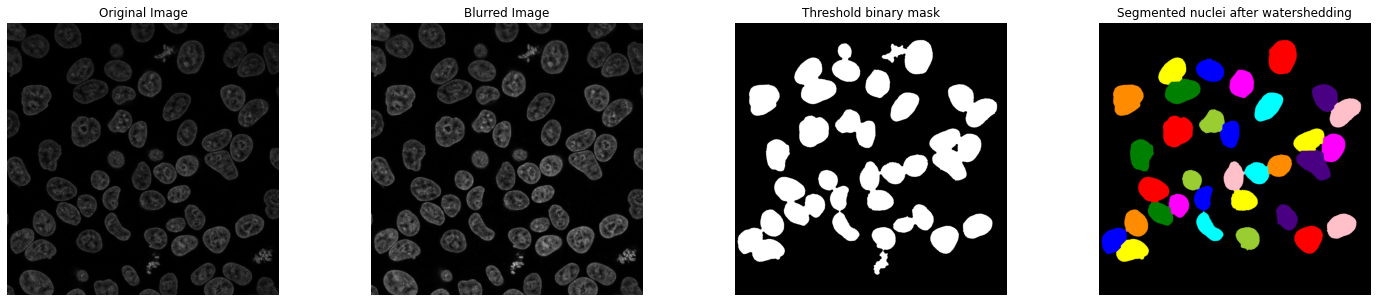

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #05.tif


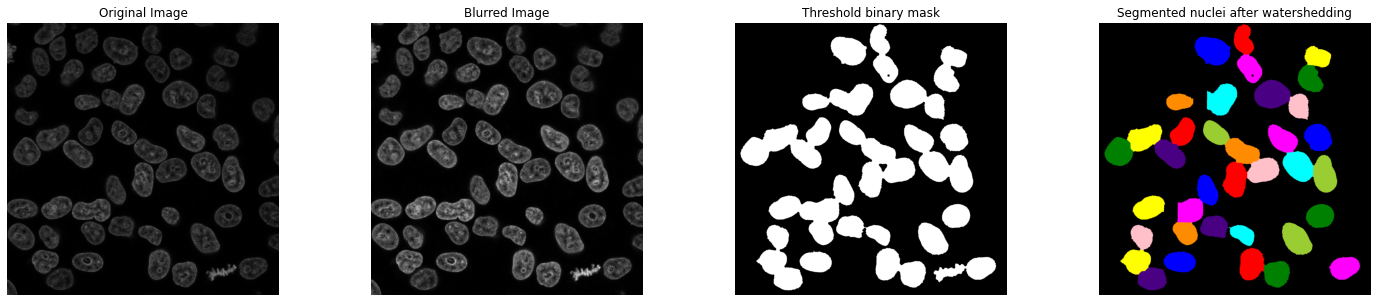

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #06.tif


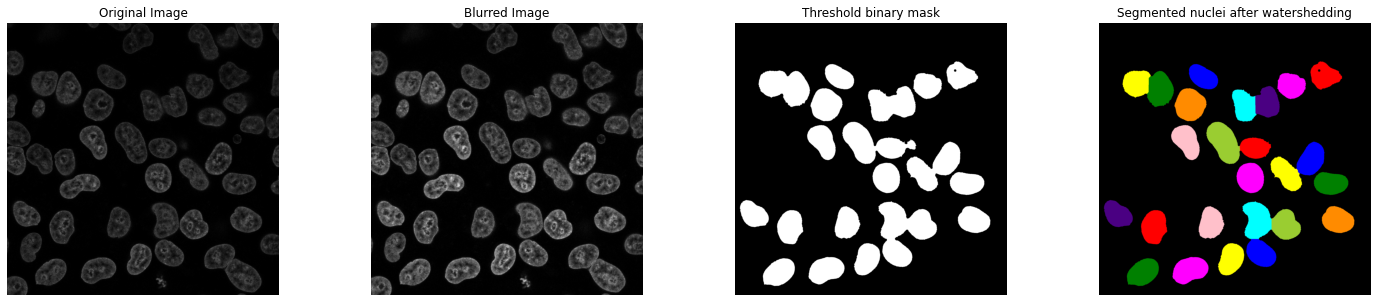

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #07.tif


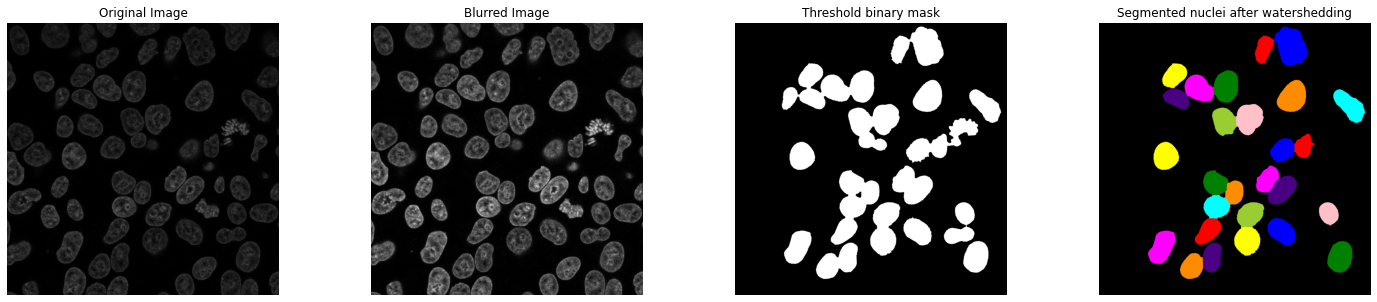

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #08.tif


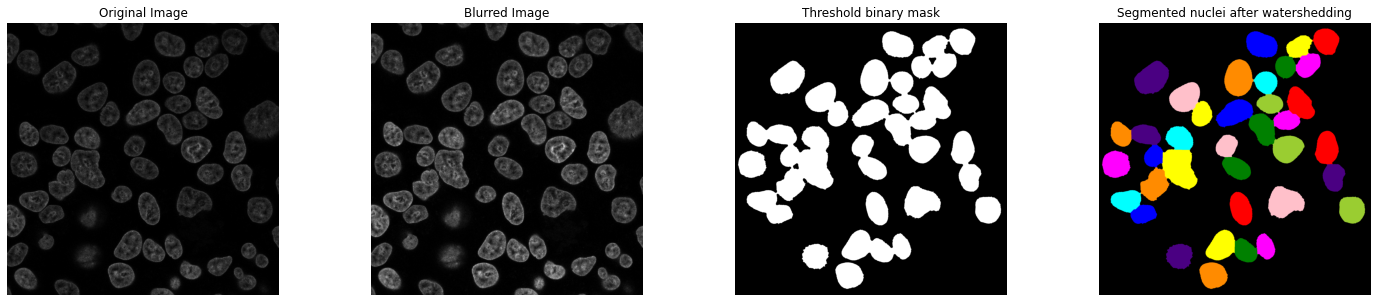

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #09.tif


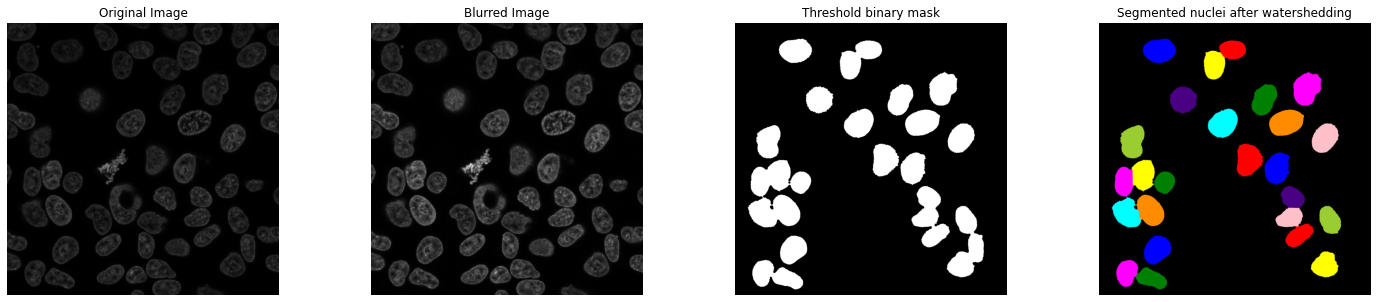

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #10.tif


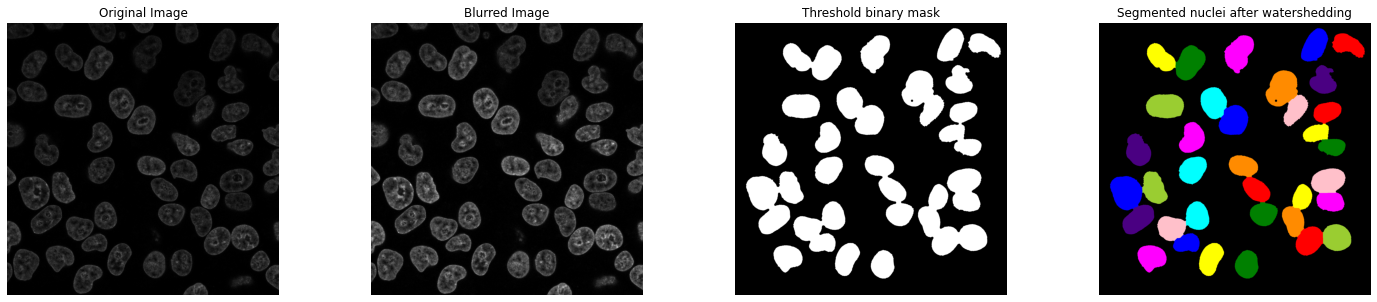

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #11.tif


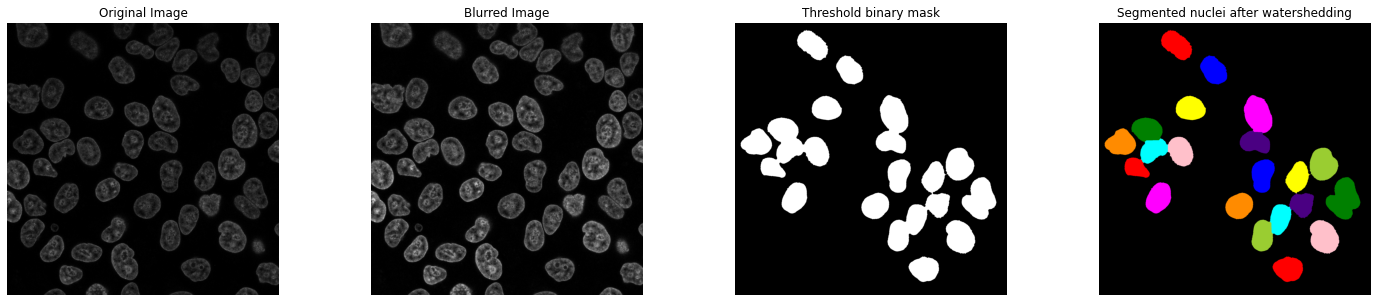

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #12.tif


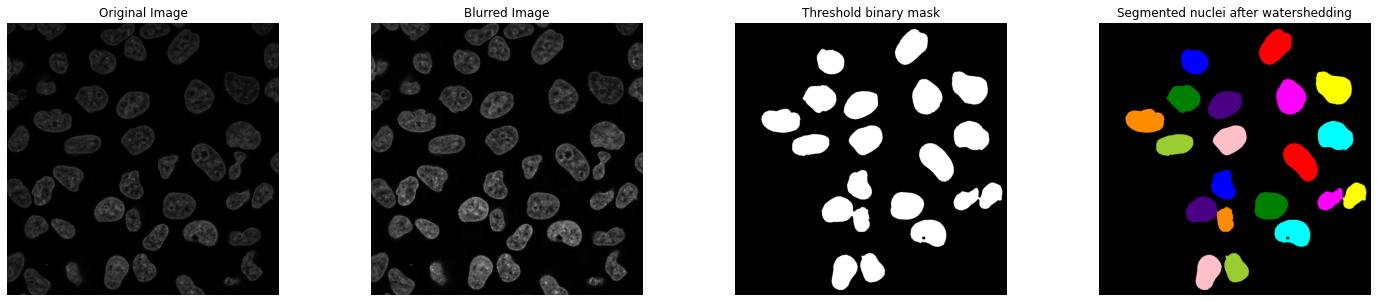

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #13.tif


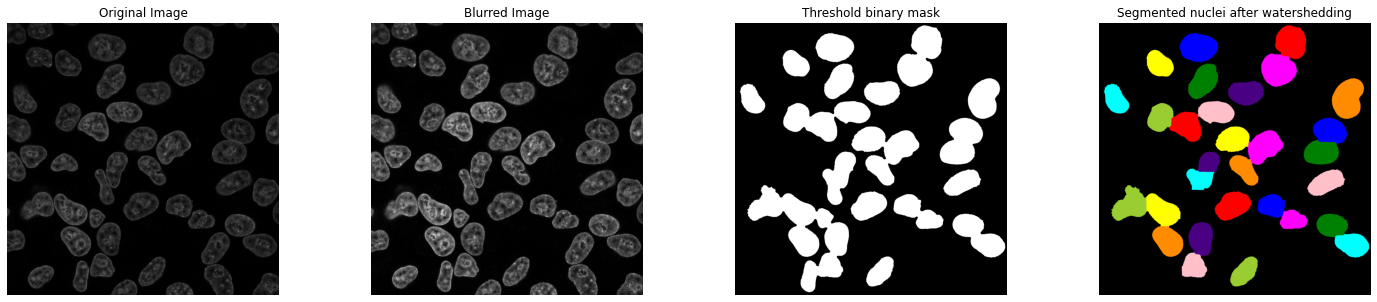

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #14.tif


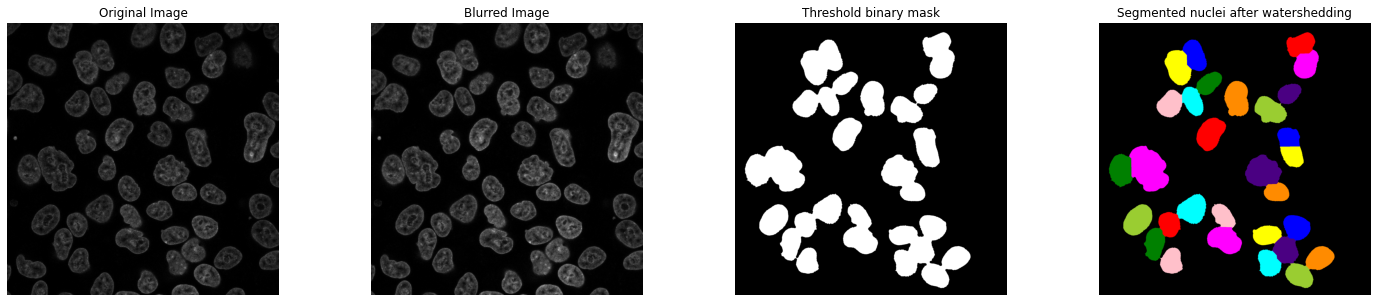

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #15.tif


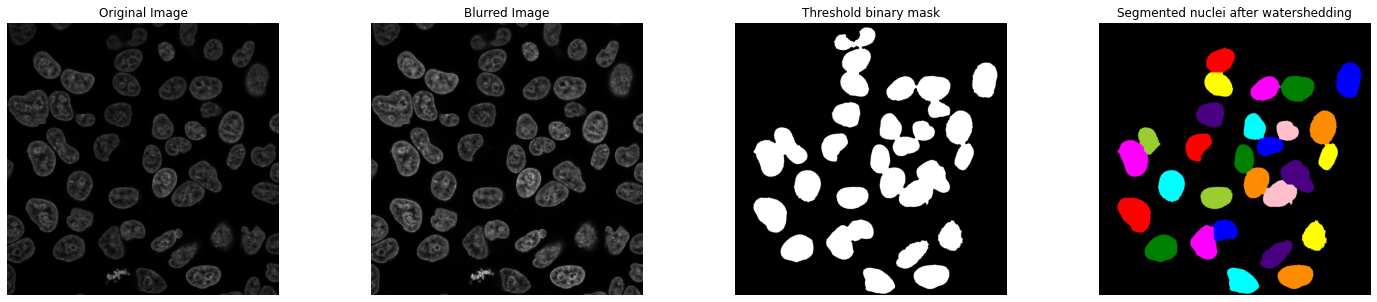

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #16.tif


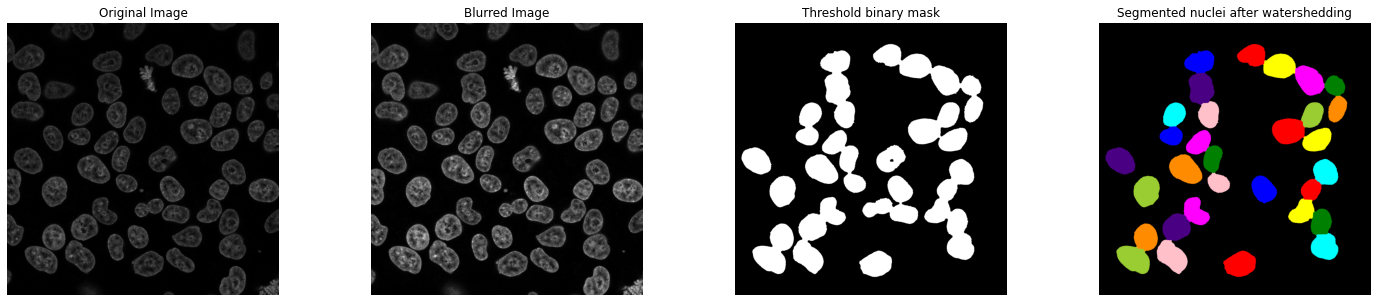

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #17.tif


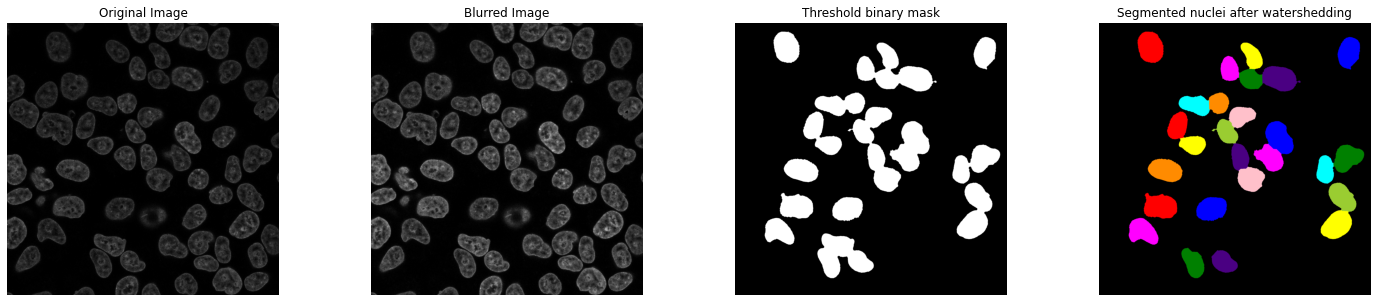

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #18.tif


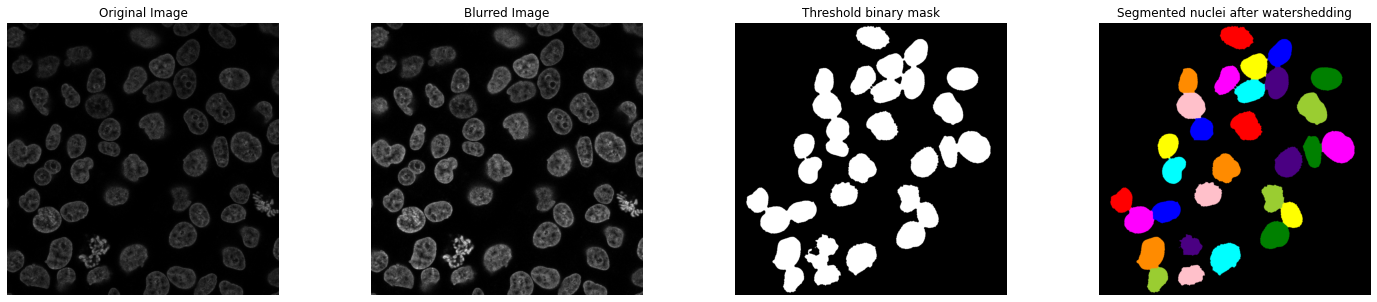

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #01.tif


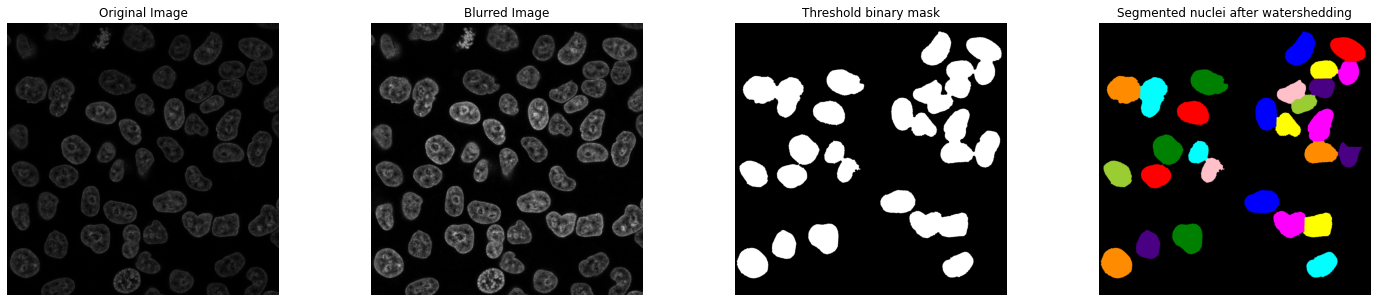

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #02.tif


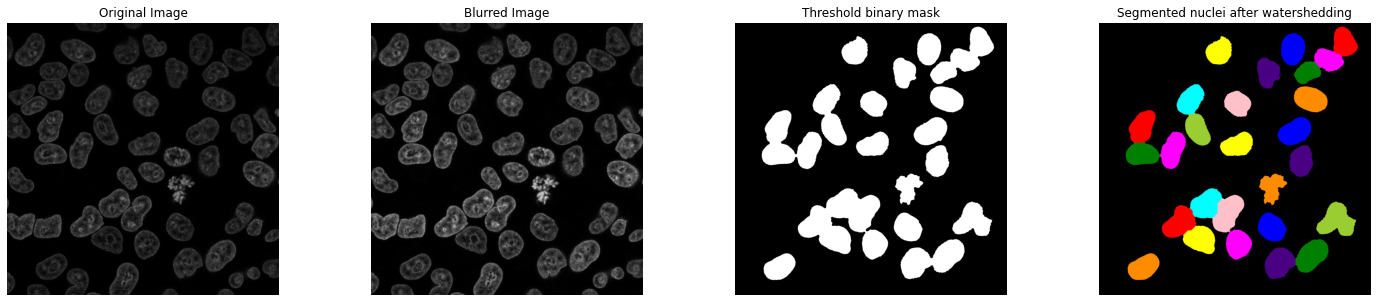

wt_stain_hoechst_halo--tmr_(wapl_settings)pos1-18 #03.tif


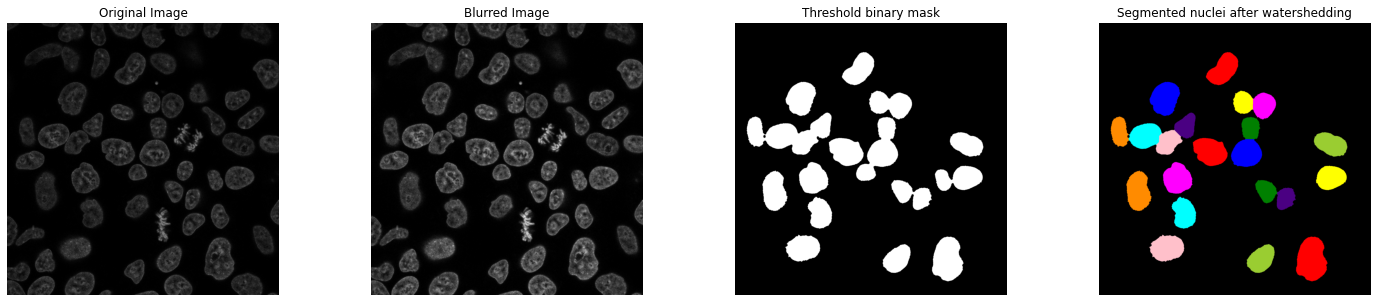

wt_stain_hoechst_halo--tmr_(wapl_settings)pos19-27 #6.tif


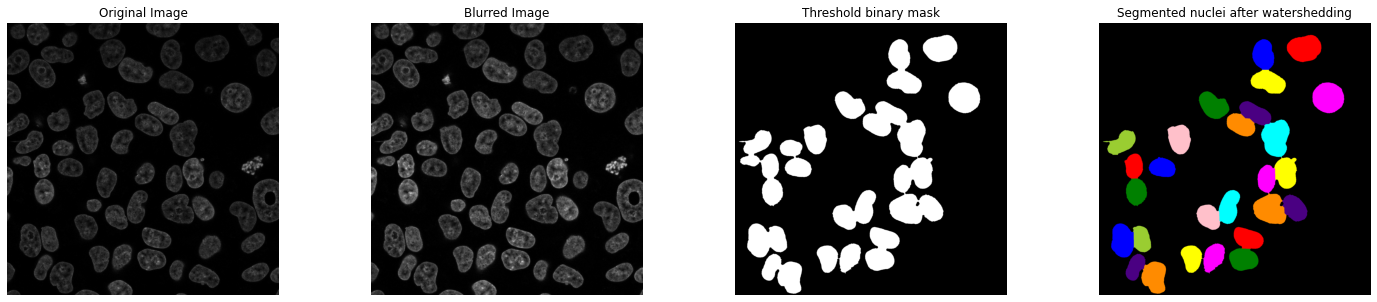

wt_stain_hoechst_halo--tmr_(wapl_settings)pos19-27 #7.tif


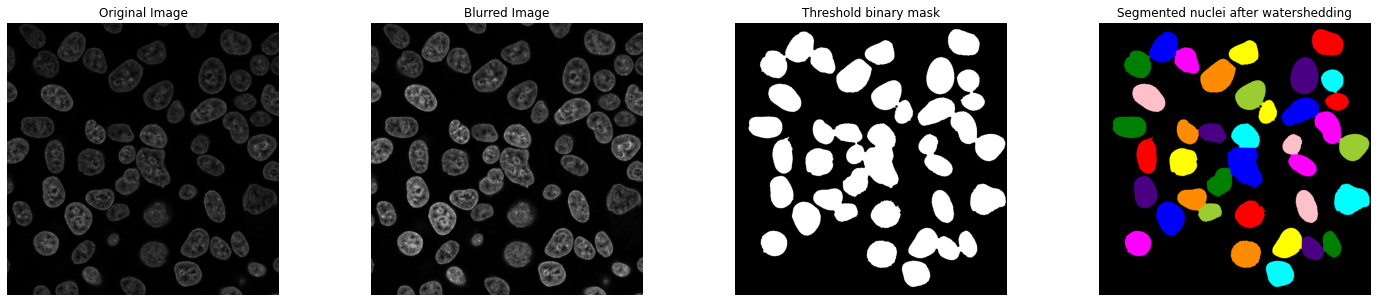

wt_stain_hoechst_halo--tmr_(wapl_settings)pos19-27 #8.tif


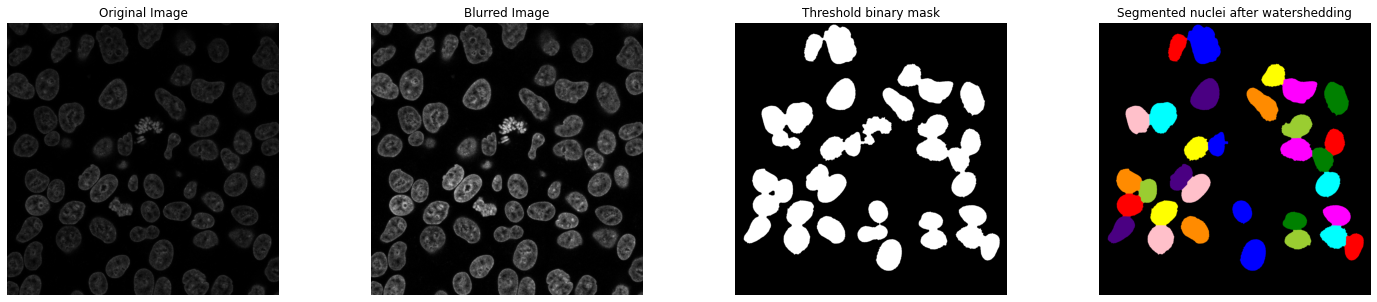

wt_stain_hoechst_halo--tmr_(wapl_settings)pos19-27 #9.tif


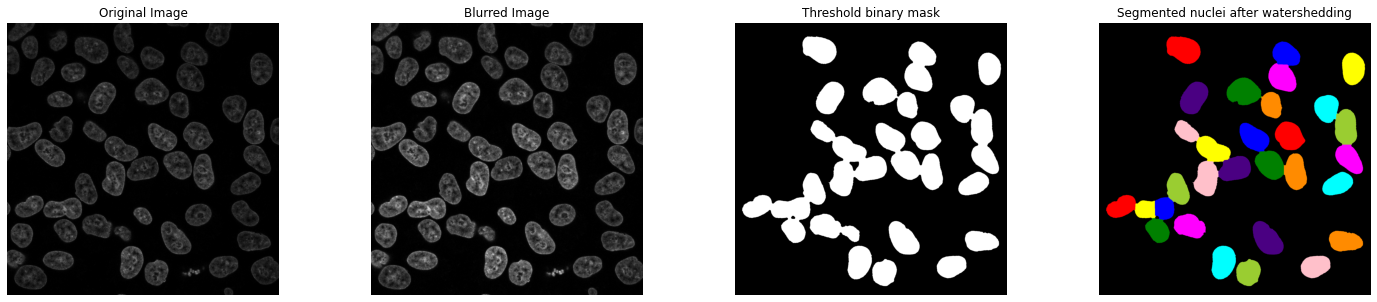

wt_stain_hoechst_halo--tmr_(wapl_settings)pos19-27 #1.tif


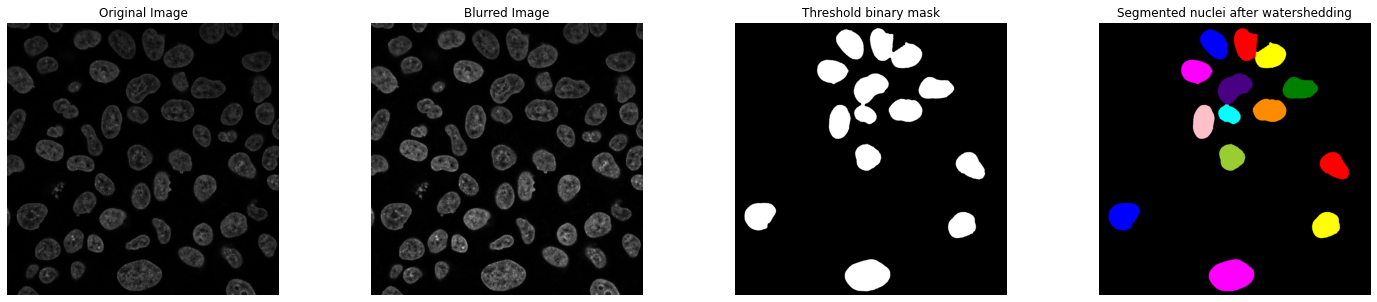

wt_stain_hoechst_halo--tmr_(wapl_settings)pos19-27 #2.tif


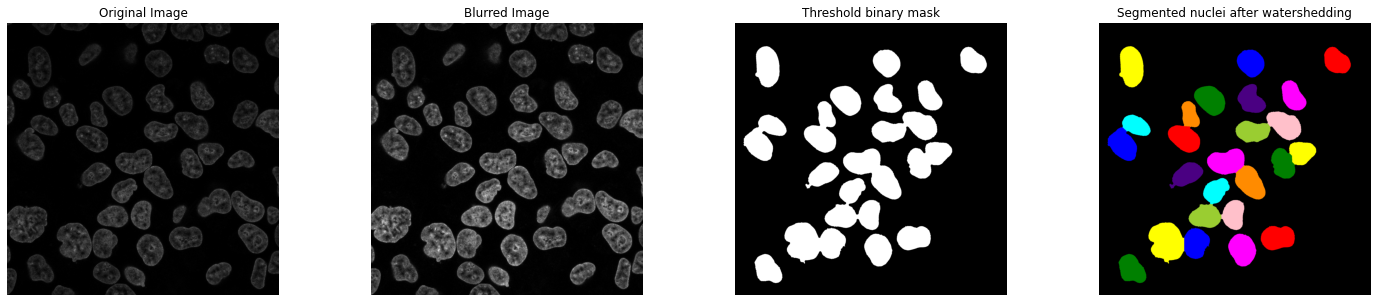

wt_stain_hoechst_halo--tmr_(wapl_settings)pos19-27 #3.tif


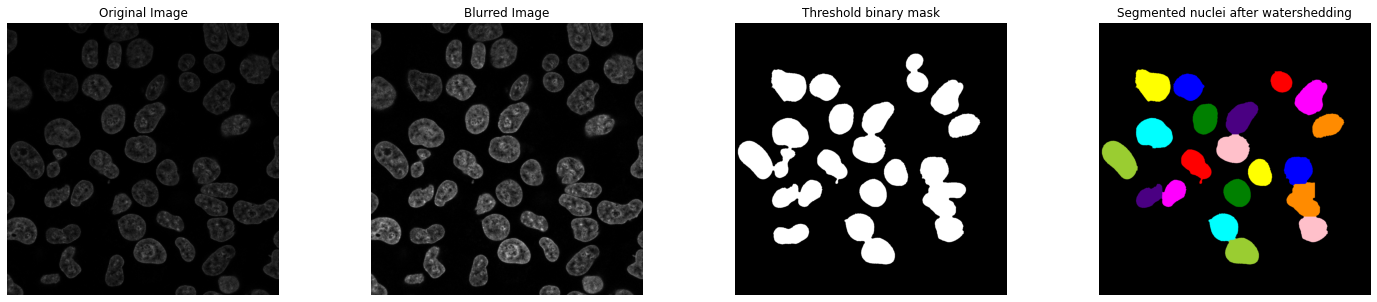

wt_stain_hoechst_halo--tmr_(wapl_settings)pos19-27 #4.tif


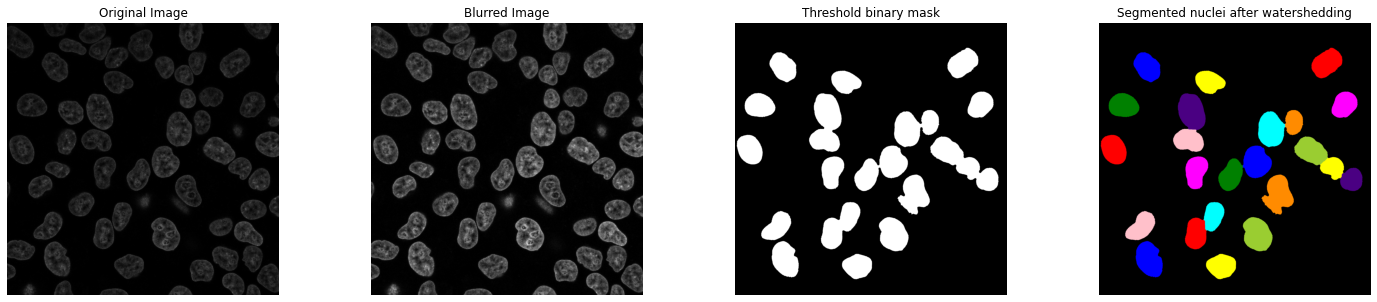

wt_stain_hoechst_halo--tmr_(wapl_settings)pos19-27 #5.tif


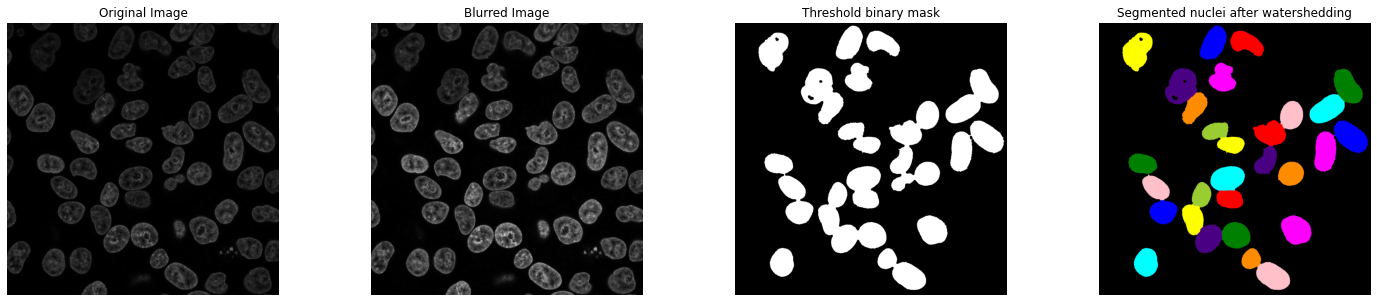

In [12]:
inpath = ("/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/attempt1_220808/1_wt/")
os.chdir(inpath)
images = glob('*.tif', recursive=True)
result = threshold_field(images)

#data = io.imread("/groups/gerlich/experiments/Experiments_005200/005223/Images/Projections/short_g2_scc1_smc4/2108_zoom5_0_control_short_G2_cycB1_SMC4_Scc1_EGFP_Hoechst-02-64.czi #1.tif_registered.tif")

In [13]:
result

nuclear_area_microns  mean_hoechst  mean_halo  total_hoechst  \
0             190.873485     15.889730   5.621558    3032.928116   
1             131.546529     14.249413   5.622964    1874.460817   
2             120.267981     14.756151   5.598128    1774.692494   
3             130.131728     19.064773   5.798829    2480.931861   
4             162.408103     12.790804   5.780774    2077.330213   
..                   ...           ...        ...            ...   
23            165.387155     22.257779   6.047019    3681.150711   
24            146.989770     26.154070   6.183183    3844.380793   
25            143.791525     23.008176   6.002217    3308.380748   
26            130.804257     19.802034   6.052748    2590.190305   
28            167.165618     23.260281   5.836900    3888.319307   

    total_nuclear_halo  std_hoechst  std_halo  coeff_variance_hoechst  \
0          1073.006392     9.260989  4.496310                0.582829   
1           739.681458     8.418124  4.535906                0.590770   
2           673.275519     8.231388  4.537821                0.557828   
3           754.611585    10.697039  4.680005                0.561089   
4           938.844476     8.147944  4.643440                0.637016   
..                 ...          ...       ...                     ...   
23         1000.099347    12.131593  4.892980                0.545050   
24          908.864661    14.415538  5.017863                0.551178   
25          863.067977    13.228321  4.810089                0.574940   
26          791.725182    10.442661  4.889789                0.527353   
28          975.728915    12.981548  4.760741                0.558099   

    coeff_variance_halo       condition  
0              0.799833  2056_minus_aux  
1              0.806675  2056_minus_aux  
2              0.810596  2056_minus_aux  
3              0.807060  2056_minus_aux  
4              0.803256  2056_minus_aux  
..                  ...             ...  
23             0.809156  2056_minus_aux  
24             0.811534  2056_minus_aux  
25             0.801385  2056_minus_aux  
26             0.807863  2056_minus_aux  
28             0.815628  2056_minus_aux  

[634 rows x 10 columns]

In [16]:
#mean nuclear Halo fluorescence is 5.87

In [17]:
result.mean_halo.mean()

5.873131070652874

In [57]:
# Testing thresholding on single image using cellpose and napari

# To do, use command line and cell pose to apply thresholding to a folder of cells

In [14]:
data = io.imread("/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/2096_minus_dtag/2096_minus_dtag_stain_hoechst_scc1_pos1-6 #06.tif")
#mask = io.imread("/groups/gerlich/experiments/Experiments_005000/005003/TIFs_registered_background_subtracted_testing/WT_fully_noR/Rep1/1/slices/20/Mask.tif")
print("shape: {}".format(data.shape))
print("dtype: {}".format(data.dtype))
print("range: ({}, {})".format(data.min(), data.max()))

#print("m shape: {}".format(mask.shape))
#print("m dtype: {}".format(mask.dtype))
#print("m range: ({}, {})".format(mask.min(), mask.max()))

shape: (2, 1912, 1912)
dtype: uint8
range: (0, 255)


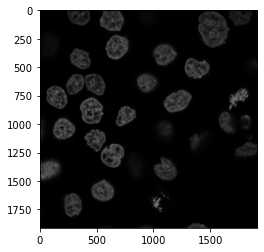

In [15]:
hoechst = data[0,:,:]
scc1 = data[1,:,:]
#wapl_ha = data[:,:,2]
display_slice(hoechst)
